In [3]:
import matplotlib.pyplot as plt
import pandas as pd
metadata_df_train_data = pd.read_csv('annotations.csv')
import os
import time
import torch
import torch.nn as nn
import torchaudio
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam
from torchsummary import summary
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import struct
import librosa
import librosa.display
import soundfile as sf
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from tensorflow.keras.utils import to_categorical
from IPython.display import Audio, display
import IPython.display as ipd
from sklearn.model_selection import train_test_split
from tensorflow import keras 
from torch.utils.data import Dataset, DataLoader
from tensorflow import keras
from torch import optim

In [2]:
import IPython.display as ipd
import os

In [3]:
def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
        print("Shape:", tuple(waveform.shape))
        print("Dtype:", waveform.dtype)
        print(f" - Max:     {waveform.max().item():6.3f}")
        print(f" - Min:     {waveform.min().item():6.3f}")
        print(f" - Mean:    {waveform.mean().item():6.3f}")
        print(f" - Std Dev: {waveform.std().item():6.3f}")
        print()
        print(waveform)
        print()
        
def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

In [4]:
wav_path = r"C:\Users\Acer\AppData\Local\Programs\Python\Python37\Scripts\project2\divine\wav_files/5f2b08db5e427.wav"
waveform, sample_rate = torchaudio.load(wav_path)
print_stats(waveform, sample_rate=sample_rate)

Sample Rate: 16000
Shape: (1, 102400)
Dtype: torch.float32
 - Max:      0.831
 - Min:     -0.994
 - Mean:     0.000
 - Std Dev:  0.135

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.8311e-04, 1.5259e-04,
         3.0518e-05]])



In [5]:
metadata = torchaudio.info(wav_path)
print (metadata)

AudioMetaData(sample_rate=16000, num_frames=102400, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [6]:
#example of output
play_audio(waveform, sample_rate)

In [7]:
metadata_df_train_data.head()

,Unnamed: 0,uttID,deviceID,Gender,Age,Region,Device_Type,Headphones,Speaker_class
0,0,5f5af4cf7bb2c,12793,F,25,East,phone,no,0
1,1,5f5af4dc52b1f,12793,F,25,East,phone,no,0
2,2,5f5af4f705da7,12793,F,25,East,phone,no,0
3,3,5f5af4fe3e8a2,12793,F,25,East,phone,no,0
4,4,5f5af5084a3be,12793,F,25,East,phone,no,0


In [8]:
metadata_df_train_data.describe()

,Unnamed: 0,deviceID,Age,Speaker_class
count,3333.00000,3333.000000,3333.000000,3333.000000
mean,1666.00000,20159.210321,39.697270,13.304830
std,962.29855,2266.152457,16.851458,8.556926
min,0.00000,12793.000000,18.000000,0.000000
25%,833.00000,20181.000000,25.000000,5.000000
50%,1666.00000,20805.000000,33.000000,14.000000
75%,2499.00000,21573.000000,62.000000,20.000000
max,3332.00000,22108.000000,65.000000,29.000000


In [9]:
metadata_df_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     3333 non-null   int64 
 1   uttID          3333 non-null   object
 2   deviceID       3333 non-null   int64 
 3   Gender         3333 non-null   object
 4   Age            3333 non-null   int64 
 5   Region         3333 non-null   object
 6   Device_Type    3333 non-null   object
 7   Headphones     3333 non-null   object
 8   Speaker_class  3333 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 234.5+ KB


In [10]:
print(metadata_df_train_data.columns)

Index(['Unnamed: 0', 'uttID', 'deviceID', 'Gender', 'Age', 'Region',
       'Device_Type', 'Headphones', 'Speaker_class'],
      dtype='object')


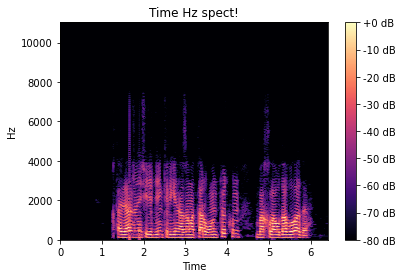

In [11]:
fig, ax = plt.subplots()
y, sr =librosa.load(wav_path)
x = librosa.stft(y)
Xdb = librosa.amplitude_to_db(np.abs(x), ref=np.max)
img = librosa.display.specshow(Xdb, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Time Hz spect!')
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [12]:
waveform, sr = librosa.load(wav_path)

In [13]:
n_fft = 2048
win_length = None
hop_length = 512
audio = librosa.stft(waveform, n_fft=n_fft, hop_length=hop_length)

In [14]:
magnitudes = np.abs(audio)**2
print(f'number of bins {magnitudes.shape[0]}, and {magnitudes.shape[1]} number of frames')

number of bins 1025, and 276 number of frames


In [15]:
def plot_spectrogram_2(Y,sr, hop_length, y_axis='log'):
    plt.figure(figsize=(20,10))
    librosa.display.specshow(Y, sr=sr, hop_length=hop_length, x_axis='time', y_axis=y_axis)
    plt.colorbar(format='%+.f')

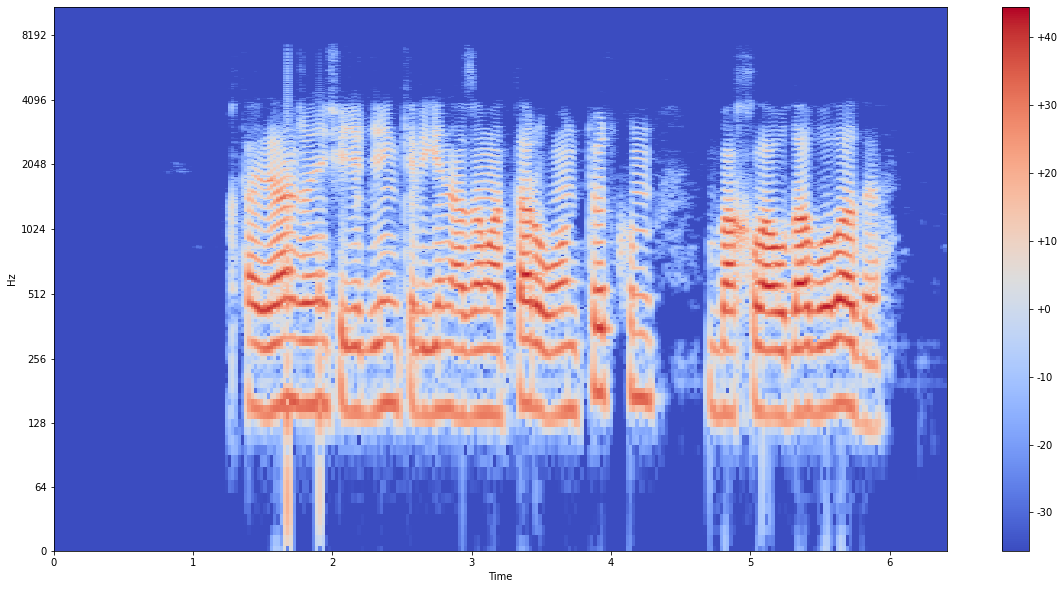

In [16]:
y_log_signal = librosa.power_to_db(magnitudes)
plot_spectrogram_2(y_log_signal, sr, hop_length)

# CREATE DATALOADER

In [19]:
import os

from torch.utils.data import Dataset
class KZSPEECH(Dataset):

    def __init__(self, annotation_file, audio_dir, transformation, target_sample_rate, num_samples):
        self.annotations = pd.read_csv(annotation_file)
        self.audio_dir = audio_dir
        self.transformation = transformation 
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        
    def __len__(self):
        return len(self.annotations)
        
    
    def __getitem__(self, index):
        audio_sample_path  = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        
        signal, sample_rate = torchaudio.load(audio_sample_path)
        
        signal = self._resample_if_necessary(signal, sample_rate) 
    
        signal = self._mix_down_if_necessary(signal) 
        #padding
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        
        signal = self.transformation(signal)
        return signal, label 
    
    def _get_audio_sample_path(self, index):
        # audio file name information is located at 1th column 
        path = os.path.join(self.audio_dir, self.annotations.iloc[index, 1])
        return path
    #padding
    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal
    
    def _get_audio_sample_label(self, index):
        
        return self.annotations.iloc[index, 2]
    
    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resample = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resample(signal)
        return signal 
    
    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal 
    
    
n_fft = 1024
hop_length = 512
n_mels = 64
win_length = None
n_mfcc = 40


SAMPLE_RATE = 20050
NUM_SAMPLES = 22050

mfcc_transform = torchaudio.transforms.MFCC(
        sample_rate=SAMPLE_RATE,
        n_mfcc=n_mfcc
    )
    


if __name__ == "__main__":
    ANNOTATIONS_FILE = r"C:/Users/Acer/AppData/Local/Programs/Python/Python37/Scripts/project2/divine/annotations2.csv"
    AUDIO_DIR = r"C:/Users/Acer/AppData/Local/Programs/Python/Python37/Scripts/project2/divine/wav_files"
    kz = KZSPEECH(ANNOTATIONS_FILE, AUDIO_DIR,mfcc_transform, SAMPLE_RATE, NUM_SAMPLES)
    print(f"There are {len(kz)} samples in the dataset.")
    signal, label = kz[0]
    print(label, signal.shape)
    print(label, signal)

There are 3333 samples in the dataset.
12793 torch.Size([1, 40, 111])
12793 tensor([[[-8.8793e+02, -8.7497e+02, -8.7339e+02,  ..., -8.4038e+02,
          -8.7407e+02, -8.9082e+02],
         [-4.3967e+01, -4.1296e+01, -3.4334e+01,  ..., -3.0132e+01,
          -2.5438e+01, -2.7790e+01],
         [-2.7390e+01, -3.0669e+01, -4.1200e+01,  ..., -5.6089e+01,
          -3.0690e+01, -3.4590e+01],
         ...,
         [-1.4375e+00, -7.5478e+00, -2.8203e+00,  ...,  4.5265e+00,
           5.3816e+00,  7.0830e+00],
         [-4.7282e+00, -2.9668e+00, -1.0006e+00,  ..., -9.2861e+00,
          -4.0559e+00,  2.9647e-01],
         [-3.2875e+00, -2.4137e+00, -4.9879e+00,  ..., -2.1525e+00,
          -4.9602e-01, -3.0816e+00]]])


c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\torchaudio\functional\functional.py:433: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


In [20]:
from torch.autograd import Variable

In [21]:
data_loader = torch.utils.data.DataLoader(kz,batch_size=1,shuffle=True)

In [22]:
%%time
for i, (inputs, targets) in enumerate(data_loader):
    with torch.no_grad():
        inputs = Variable(inputs)
        targets = Variable(targets)
        print(inputs, targets)

tensor([[[[-7.6367e+02, -7.6532e+02, -7.6624e+02,  ..., -4.0659e+02,
           -4.2444e+02, -4.3933e+02],
          [-1.7013e+00, -5.1314e-01, -2.5021e-01,  ...,  5.9275e+01,
            1.7761e+01,  8.9299e+01],
          [-6.6697e-01, -6.3792e-01,  7.0195e-02,  ..., -4.1583e+01,
            2.1425e+01,  5.1722e-01],
          ...,
          [ 1.3539e+00, -4.3759e-01, -3.1636e-01,  ...,  2.4008e-01,
           -3.5598e-01, -2.2864e+00],
          [-8.0354e-02,  4.2303e-01,  2.7866e-01,  ..., -7.9351e+00,
           -7.8151e+00, -7.3945e+00],
          [-3.5411e-01, -4.7261e-01, -1.1920e-01,  ..., -7.8415e+00,
           -2.4732e+01, -1.6403e+01]]]]) tensor([12793])
tensor([[[[-8.4281e+02, -8.3217e+02, -8.3778e+02,  ..., -6.9494e+02,
           -6.9810e+02, -5.7506e+02],
          [-1.5862e+01, -1.7848e+01, -1.0034e+01,  ...,  1.3648e+02,
            1.3712e+02,  1.4895e+02],
          [-7.3766e+00, -1.0570e+01, -9.8765e+00,  ...,  5.4264e+01,
            6.1130e+01,  1.5648e+01],
   

# EDA

In [23]:
metadata_df_train_data.head()

,Unnamed: 0,uttID,deviceID,Gender,Age,Region,Device_Type,Headphones,Speaker_class
0,0,5f5af4cf7bb2c,12793,F,25,East,phone,no,0
1,1,5f5af4dc52b1f,12793,F,25,East,phone,no,0
2,2,5f5af4f705da7,12793,F,25,East,phone,no,0
3,3,5f5af4fe3e8a2,12793,F,25,East,phone,no,0
4,4,5f5af5084a3be,12793,F,25,East,phone,no,0


In [24]:
metadata_df_train_data['uttID'] = metadata_df_train_data['uttID'] + ".wav"

In [25]:
metadata_df_train_data['Headphones'].unique()

array(['no', 'yes'], dtype=object)

In [26]:
metadata_df_train_data['Gender'] = metadata_df_train_data['Gender'].map({'F':1 ,'M':0})

In [27]:
metadata_df_train_data['Headphones'] = metadata_df_train_data['Headphones'].map({'yes':1 ,'no':0})

In [28]:
one_hot = pd.get_dummies(metadata_df_train_data, columns = ['Region', 'Device_Type'])

In [29]:
df = one_hot

In [30]:
from sklearn.model_selection import train_test_split
from fast_ml.model_development import train_valid_test_split

In [31]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df, target = 'Speaker_class', 
                                                                            train_size=0.6, valid_size=0.1, test_size=0.3)

In [32]:

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(1999, 13)
(1999,)
(333, 13)
(333,)
(1001, 13)
(1001,)


(None, None)

In [33]:
X_train.drop(['Unnamed: 0','deviceID'], axis=1, inplace=True)

In [34]:
X_train

,uttID,Gender,Age,Headphones,Region_Central,Region_East,Region_North,Region_South,Region_West,Device_Type_computer,Device_Type_phone
1554,5f5eecd744a59.wav,1,56,0,0,0,0,1,0,0,1
447,5f5f24c9abf40.wav,1,63,0,0,0,1,0,0,0,1
711,5f5792a3d587b.wav,1,33,0,0,1,0,0,0,0,1
819,5fa2596130426.wav,1,33,0,0,1,0,0,0,0,1
1014,5f609824500e4.wav,0,19,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
58,5f5af78052a9c.wav,1,25,0,0,1,0,0,0,0,1
1092,5f58ff07da554.wav,1,19,0,0,0,0,1,0,0,1
2388,5f618b1ee5e9b.wav,0,25,0,0,1,0,0,0,0,1
101,5f2b0758d3806.wav,0,63,0,0,0,1,0,0,0,1


In [ ]:
X_train.to_csv('KSC_train.csv')

In [35]:
X_test

,Unnamed: 0,uttID,deviceID,Gender,Age,Headphones,Region_Central,Region_East,Region_North,Region_South,Region_West,Device_Type_computer,Device_Type_phone
1975,1975,5f60c58747c64.wav,20872,0,65,0,0,0,0,1,0,0,1
2947,2947,5f60fdda65ae3.wav,21985,0,39,0,0,0,1,0,0,0,1
2871,2871,5f60e88297ec5.wav,21864,1,29,0,0,0,0,0,1,0,1
2465,2465,5f60def699085.wav,21573,0,40,1,0,1,0,0,0,0,1
3266,3266,5f61e6a6d1102.wav,22108,0,21,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,3120,5f6198169a1d1.wav,22042,1,51,0,0,0,0,1,0,0,1
416,416,5f59c0944f4de.wav,15872,1,63,0,0,0,1,0,0,0,1
1867,1867,5f60b15d8b10a.wav,20872,0,65,0,0,0,0,1,0,0,1
1152,1152,5f58decd02196.wav,20565,1,62,1,0,0,0,1,0,0,1


In [36]:
X_valid

,Unnamed: 0,uttID,deviceID,Gender,Age,Headphones,Region_Central,Region_East,Region_North,Region_South,Region_West,Device_Type_computer,Device_Type_phone
2541,2541,5f60bb0b58ad1.wav,21773,0,51,1,0,0,1,0,0,1,0
884,884,5f579a7ad9c8e.wav,20185,0,21,0,0,0,0,1,0,1,0
1860,1860,5f60b07fe6463.wav,20872,0,65,0,0,0,0,1,0,0,1
2850,2850,5f60e728897fb.wav,21864,1,29,0,0,0,0,0,1,0,1
3145,3145,5f61dfb0caece.wav,22073,0,21,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3069,3069,5f6189ea4955a.wav,22037,0,38,0,1,0,0,0,0,0,1
1436,1436,5f5a3824b7023.wav,20715,1,28,0,1,0,0,0,0,0,1
510,510,5f5fb675ac073.wav,15872,1,63,0,0,0,1,0,0,0,1
1371,1371,5f5ef046b8b4e.wav,20678,1,31,0,0,0,0,0,1,0,1


In [ ]:
X_train.to_csv('KSC_valid.csv')

In [37]:
arr1 = list(X_train["uttID"])
arr2 = y_train 
zipped = zip(arr1, arr2)
zipped = list(zipped)
print("Initial zipped list - ", str(zipped))
res = sorted(zipped, key = lambda x: x[1])
print("final list - ", str(res))

Initial zipped list -  [('5f5eecd744a59.wav', 13), ('5f5f24c9abf40.wav', 2), ('5f5792a3d587b.wav', 5), ('5fa2596130426.wav', 5), ('5f609824500e4.wav', 7), ('5f60c6787a377.wav', 22), ('5f58809f931c5.wav', 7), ('5f61e3f89b208.wav', 28), ('5f60e4406a369.wav', 23), ('5f5c9c59957b0.wav', 8), ('5f60e36145279.wav', 23), ('5f58abd8727b2.wav', 8), ('5f6304d34b926.wav', 15), ('5f58e06188fef.wav', 9), ('5f60bfebc11c2.wav', 21), ('5f5af66ab89b0.wav', 0), ('5f60fe0e313ab.wav', 25), ('5f5791d9e44d5.wav', 5), ('5f57991866209.wav', 5), ('5f60e67b05134.wav', 24), ('5f579be718df4.wav', 5), ('5f60963fe60b5.wav', 7), ('5fa12bd6dd2bf.wav', 26), ('5f5a55c5f1faf.wav', 13), ('5f6065b29b9ae.wav', 20), ('5f5a5b3dae1f6.wav', 14), ('5f60e823350d1.wav', 23), ('5f58ddb8b09eb.wav', 9), ('5f59be962596c.wav', 2), ('5f618828dc5a0.wav', 26), ('5f59bf2da2630.wav', 2), ('5f62ee9f3fd42.wav', 26), ('5f60b040065fb.wav', 17), ('5fa4f465c3fe0.wav', 21), ('5fa136fc9cb50.wav', 2), ('5f579aabf17f9.wav', 5), ('5f9f9eb100c28.wav', 

In [38]:
datafile = open("train_file.txt".format("train_file"), "w")
for audio_file, speaker in res:
    datafile.write(audio_file + "-" + str(speaker) + "\n")
datafile.close()

In [39]:
arr1 = list(X_test["uttID"])
arr2 = y_test
zipped = zip(arr1, arr2)
zipped = list(zipped)
print("Initial zipped list - ", str(zipped))
res_test = sorted(zipped, key = lambda x: x[1])
print("final list - ", str(res))

Initial zipped list -  [('5f60c58747c64.wav', 15), ('5f60fdda65ae3.wav', 25), ('5f60e88297ec5.wav', 24), ('5f60def699085.wav', 20), ('5f61e6a6d1102.wav', 29), ('5f5c99ae0b03c.wav', 8), ('5f5c4ee032d25.wav', 16), ('5f6096aede778.wav', 15), ('5f609772612b1.wav', 7), ('5f9fbec9365c3.wav', 8), ('5f60e7e16971b.wav', 23), ('5f618894c9171.wav', 26), ('5f58ddf252f80.wav', 9), ('5fa3ab229bf84.wav', 12), ('5f60e4d646532.wav', 23), ('5f5c4e26e95ac.wav', 16), ('5f5a5732692ff.wav', 13), ('5f60c61e4790a.wav', 15), ('5f60c1e095f6e.wav', 15), ('5f579aa10c2d7.wav', 5), ('5f57aebd3c28f.wav', 6), ('5f568680b8321.wav', 1), ('5f5f3b5ec4999.wav', 3), ('5f6187c420655.wav', 26), ('5f6335045db41.wav', 28), ('5f57747e18982.wav', 4), ('5f60af090ac2b.wav', 15), ('5f6198e5d982a.wav', 17), ('5f5a58d5271d6.wav', 14), ('5f60a77873928.wav', 15), ('5f58855d6b880.wav', 7), ('5f61ebdcac60e.wav', 29), ('5f58c87084463.wav', 10), ('5f60a740e79fd.wav', 15), ('5f5883c6350b9.wav', 7), ('5f5fb7d9121f6.wav', 14), ('5f5f9d40eb0cc

In [40]:
datafile = open("test_file.txt".format("test_file"), "w")
for audio_file, speaker_class in res_test:
    datafile.write(audio_file + "-" + str(speaker_class) + "\n")
datafile.close()

In [41]:
count_class = y_train.value_counts()

In [42]:
sorted_class = {k: v for k, v in sorted(count_class.items(), key=lambda item: item[0])}

In [43]:
sorted_class

{0: 62,
 1: 124,
 2: 137,
 3: 57,
 4: 35,
 5: 116,
 6: 20,
 7: 71,
 8: 55,
 9: 56,
 10: 45,
 11: 59,
 12: 58,
 13: 51,
 14: 49,
 15: 214,
 16: 63,
 17: 32,
 18: 68,
 19: 66,
 20: 71,
 21: 62,
 22: 62,
 23: 61,
 24: 57,
 25: 55,
 26: 63,
 27: 8,
 28: 59,
 29: 63}

# FEATURE EXTRACTION 

In [44]:
import numpy as np
from sklearn import preprocessing
import python_speech_features as mfcc
def calculate_delta(array):
    """Calculate and returns the delta of given feature vector matrix"""

    rows,cols = array.shape
    deltas = np.zeros((rows,20))
    N = 2
    for i in range(rows):
        index = []
        j = 1
        while j <= N:
            if i-j < 0:
                first = 0
            else:
                first = i-j
            if i+j > rows -1:
                second = rows -1
            else:
                second = i+j
            index.append((second,first))
            j+=1
        deltas[i] = ( array[index[0][0]]-array[index[0][1]] + (2 * (array[index[1][0]]-array[index[1][1]])) ) / 10
    return deltas

def extract_features(audio,rate):
    """extract 20 dim mfcc features from an audio, performs CMS and combines 
    delta to make it 40 dim feature vector"""    
    
    mfcc_feat = mfcc.mfcc(audio,rate, 0.025, 0.01,20,appendEnergy = True)
    
    mfcc_feat = preprocessing.scale(mfcc_feat)
    delta = calculate_delta(mfcc_feat)
    combined = np.hstack((mfcc_feat,delta)) 
    return combined

# GMM

In [47]:
import pickle
import numpy as np
from scipy.io.wavfile import read
from sklearn.mixture import GaussianMixture
import warnings


# path to training data 
source = r"C:/Users/Acer/AppData/Local/Programs/Python/Python37/Scripts/project2/divine/wav_files//"
train_file = "train_file.txt"
# path where training speakers will be saved  
dest ='speaker_models/'
file_paths = open(train_file, 'r')

count = 1
# Extracting features for each speaker (5 files per speakers)
features = np.asarray(())
for path in file_paths:
    path = path.strip() #get path and class from txt 
    split_string = path.split("-")
    path_file = split_string[0]
    path_class = split_string[1]
#     print (path)
 
    # read the audio
    sr,audio = read(source + path_file)
 
    # extract 40 dimensional MFCC & delta MFCC features
    vector   = extract_features(audio,sr)
 
    if features.size == 0:
        features = vector
    else:
        features = np.vstack((features, vector)) 
#     
    if count == sorted_class[int(path_class)]:
        print(count, path_class, sorted_class[int(path_class)]) 
        gmm = GaussianMixture(n_components = 16, max_iter = 200, covariance_type='diag',n_init = 3)
        gmm.fit(features)
 
        # dumping the trained gaussian model
        picklefile = path_class +".gmm" # 
        pickle.dump(gmm,open(dest + picklefile,'wb'))
        print ('+ modeling completed for speaker:',picklefile," with data point = ",features.shape)
        features = np.asarray(())
        count = 0
    count = count + 1

62 0 62
+ modeling completed for speaker: 0.gmm  with data point =  (39195, 40)
124 1 124
+ modeling completed for speaker: 1.gmm  with data point =  (116380, 40)
137 2 137
+ modeling completed for speaker: 2.gmm  with data point =  (129787, 40)
57 3 57
+ modeling completed for speaker: 3.gmm  with data point =  (43942, 40)
35 4 35
+ modeling completed for speaker: 4.gmm  with data point =  (23402, 40)
116 5 116
+ modeling completed for speaker: 5.gmm  with data point =  (68169, 40)
20 6 20
+ modeling completed for speaker: 6.gmm  with data point =  (15134, 40)
71 7 71
+ modeling completed for speaker: 7.gmm  with data point =  (45988, 40)
55 8 55
+ modeling completed for speaker: 8.gmm  with data point =  (35088, 40)
56 9 56
+ modeling completed for speaker: 9.gmm  with data point =  (43441, 40)
45 10 45
+ modeling completed for speaker: 10.gmm  with data point =  (25963, 40)
59 11 59
+ modeling completed for speaker: 11.gmm  with data point =  (41196, 40)
58 12 58
+ modeling complete

In [48]:
import os
import time
 
#path to training data
source   = "wav_files/"
modelpath = "speaker_models/"
test_file = "test_file.txt"
file_paths = open(test_file,'r')

gmm_files = [os.path.join(modelpath, fname) for fname in os.listdir(modelpath) if fname.endswith('.gmm')]
models =  [pickle.load(open(fname,'rb')) for fname in gmm_files]
speakers = [fname.split('/')[-1].split('.gmm')[0] for fname in gmm_files]
error = 0.0
total_sample = 0.0
for path in file_paths:
  
    
    total_sample += 1.0
    path = path.strip()  
    path_file = path.split("-") 
    print ("Testing Audio : ", path_file[1])
    sr,audio = read(source + path_file[0])
    vector   = extract_features(audio,sr)
    
    log_likelihood = np.zeros(len(models))
    
    for i in range(len(models)):
        gmm = models[i]
        scores = np.array(gmm.score(vector))
        log_likelihood[i] = scores.sum()
    winner = np.argmax(log_likelihood)
    print ("\tdetected as - ", speakers[winner])
    checker_name = path.split("-")[1]
    if str(speakers[winner]) != str(checker_name):
        error += 1

Testing Audio :  0
	detected as -  0
Testing Audio :  0
	detected as -  0
Testing Audio :  0
	detected as -  0
Testing Audio :  0
	detected as -  0
Testing Audio :  0
	detected as -  0
Testing Audio :  0
	detected as -  0
Testing Audio :  0
	detected as -  0
Testing Audio :  0
	detected as -  0
Testing Audio :  0
	detected as -  0
Testing Audio :  0
	detected as -  0
Testing Audio :  0
	detected as -  0
Testing Audio :  0
	detected as -  0
Testing Audio :  0
	detected as -  0
Testing Audio :  0
	detected as -  0
Testing Audio :  0
	detected as -  0
Testing Audio :  0
	detected as -  0
Testing Audio :  0
	detected as -  0
Testing Audio :  0
	detected as -  0
Testing Audio :  0
	detected as -  0
Testing Audio :  0
	detected as -  0
Testing Audio :  0
	detected as -  0
Testing Audio :  0
	detected as -  0
Testing Audio :  0
	detected as -  0
Testing Audio :  0
	detected as -  0
Testing Audio :  0
	detected as -  0
Testing Audio :  0
	detected as -  0
Testing Audio :  0
	detected as -  0
T

In [49]:
print (error, total_sample)
accuracy = ((total_sample - error) / total_sample) * 100
print ("The Accuracy Percentage for the current testing Performance with MFCC + GMM is : ", accuracy, "%")

21.0 1001.0
The Accuracy Percentage for the current testing Performance with MFCC + GMM is :  97.9020979020979 %


# CNN

In [50]:
def read_wav_file(path, file):
    data, samplerate = sf.read(path+file)
    return data, samplerate


def extract_mfcc(wav_file_name):
    y, sr = librosa.load(wav_file_name)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T,axis=0)
    
    return mfccs

def create_data_loader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    return train_dataloader

def train_single_epoch(model, data_loader, loss_fn, optimiser, device):
    for input, target in data_loader:
        input, target = input.to(device), target
        
        prediction = model(input)
        loss = loss_fn(prediction, target)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    print(f"loss: {loss.item()}")


def train(model, data_loader, loss_fn, optimiser, device, epochs):
    for i in range(epochs):
        print(f"Epoch {i+1}")
        train_single_epoch(model, data_loader, loss_fn, optimiser, device)
        print("---------------------------")

In [51]:
class CNNNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(128 * 5 * 4, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        logits = self.linear(x)
        predictions = self.softmax(logits)
        return predictions

In [52]:
cnn = CNNNetwork()
summary(cnn, (1, 64, 44))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 66, 46]             160
              ReLU-2           [-1, 16, 66, 46]               0
         MaxPool2d-3           [-1, 16, 33, 23]               0
            Conv2d-4           [-1, 32, 35, 25]           4,640
              ReLU-5           [-1, 32, 35, 25]               0
         MaxPool2d-6           [-1, 32, 17, 12]               0
            Conv2d-7           [-1, 64, 19, 14]          18,496
              ReLU-8           [-1, 64, 19, 14]               0
         MaxPool2d-9             [-1, 64, 9, 7]               0
           Conv2d-10           [-1, 128, 11, 9]          73,856
             ReLU-11           [-1, 128, 11, 9]               0
        MaxPool2d-12            [-1, 128, 5, 4]               0
          Flatten-13                 [-1, 2560]               0
           Linear-14                   

In [20]:
annotations_file_train = 'KSC_train.csv'
annotations_file_val = 'KSC_valid.csv'

audio_dir = 'wav_files'

sample_rate = 22050
mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate, n_fft=1024, hop_length=512, n_mels=64)
num_samples = 22050

batch_size = 128
epochs = 60
learning_rate = 0.001
 


ksc_train = KZSPEECH(annotations_file_train, audio_dir, mel_spectrogram, sample_rate, num_samples)
ksc_val = KZSPEECH(annotations_file_val, audio_dir, mel_spectrogram, sample_rate, num_samples)

train_dataloader = create_data_loader(ksc_train, batch_size)
val_dataloader = create_data_loader(ksc_val, batch_size)

cnn = CNNNetwork()
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(cnn.parameters(),
                                 lr=learning_rate)

train(cnn, train_dataloader, loss_fn, optimiser, device, epochs)

Epoch 1
loss: 2.2747440338134766, accuracy: 0.16176470588235295
---------------------------
Epoch 2
loss: 2.271786689758301, accuracy: 0.08823529411764706
---------------------------
Epoch 3
loss: 2.2641429901123047, accuracy: 0.16176470588235295
---------------------------
Epoch 4
loss: 2.257689952850342, accuracy: 0.19117647058823528
---------------------------
Epoch 5
loss: 2.2489569187164307, accuracy: 0.19117647058823528
---------------------------
Epoch 6
loss: 2.2431588172912598, accuracy: 0.17647058823529413
---------------------------
Epoch 7
loss: 2.2367706298828125, accuracy: 0.19117647058823528
---------------------------
Epoch 8
loss: 2.2385973930358887, accuracy: 0.14705882352941177
---------------------------
Epoch 9
loss: 2.2343204021453857, accuracy: 0.14705882352941177
---------------------------
Epoch 10
loss: 2.224785327911377, accuracy: 0.20588235294117646
---------------------------
Epoch 11
loss: 2.2248353958129883, accuracy: 0.25
---------------------------
Epoc

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classification_models = [
    KNeighborsClassifier(),#(3),
    SVC(kernel='linear'),#, C=0.025),
    SVC(kernel='rbf'),
    DecisionTreeClassifier(),#max_depth=5),
    RandomForestClassifier(),#max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    QuadraticDiscriminantAnalysis()]

scores = []
for model in classification_models:
    model.fit(X_train_scaled, y_train)
    score = model.score(X_test_scaled, y_test)
    model_name = type(model).__name__
    if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
    scores.append((model_name,(f'{100*score:.2f}%')))
# Make it pretty
scores_df = pd.DataFrame(scores,columns=['Classifier','Accuracy Score'])
scores_df.sort_values(by='Accuracy Score',axis=0,ascending=False)

,Classifier,Accuracy Score
4,DTW,82%
5,Vector Quantization,74.28%
3,SVC,68.19%
0,SVC RBF kernel,52.70%
1,RandomForestClassifier,48.61%
2,KNeighborsClassifier,47.92%
6,DecisionTreeClassifier,34.00%
7,AdaBoostClassifier,31.70%
